In [1]:
df.head()

NameError: name 'df' is not defined

## Introduction

This is an analysis of Los Angeles Crime Data. 

Time Period: 2015-2019

Dataset source:
https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/y8tr-7khq

Hope to show some insights from the data including:

    -What type of crime is most prevalent?
    -What type of crime is least prevalent?
    -Where was there more crime? Show on Map
    -Where was there less crime? Show on Map
    -Where did most batteries occured? Show on Map
    -When did crimes occured? Show on Plot
    -Show crime by area_name
    
    Lastly we want to show whether or not crime is increasing or decreasing in the city of Angels
    -Is crime increasing or decreasing in time? Show on Plot

In [2]:
import os
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import numpy as np
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster
from pandas import datetime
from IPython.display import Image

%matplotlib inline

In [5]:
##Our cast of characters

#crime data
df = pd.read_csv('/Users/nonoumasy/Downloads/data/LA_Crime_Data_from_2010_to_Present.csv')


In [6]:
##clean the data

#keep only relevant columns
df = df[['Date Occurred','Time Occurred','Area Name','Crime Code','Crime Code Description','Weapon Description','Address','Location ']]

#column cleanup
df.columns = df.columns.str.lower().str.replace('\W+', '_').str.replace('(', '').str.replace(')', '')

#convert location column str to float
df.location_ = df.location_.astype(str).str.replace('(', '').str.replace(')', '').str.split(',').apply(lambda lst: [float(x.strip()) for x in lst])

#cleanup time_occurred column
df.time_occurred = df.time_occurred.astype(str).str.pad(width=4, fillchar='0').map(lambda a : a[:-2] + ":" + a[-2:] )

#combine date and time together
combined = df.date_occurred.str.cat(df.time_occurred, sep=' ')

#convert to datetime format
df['datetime_series'] = pd.to_datetime(combined)

#map weekday to weekday name
df['weekday_name'] = df.datetime_series.dt.weekday_name



In [35]:
# %load /Users/nonoumasy/Downloads/data/crime_level.py
felony_list = \
[
'VEHICLE - STOLEN', 
'INTIMATE PARTNER - SIMPLE ASSAULT', 
'PIMPING', 
'INTIMATE PARTNER - AGGRAVATED ASSAULT', 
'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
'BATTERY WITH SEXUAL CONTACT', 
'RAPE, FORCIBLE', 'ORAL COPULATION',
'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 
'ROBBERY',
'BATTERY - SIMPLE ASSAULT', 
'KIDNAPPING',
'CHILD NEGLECT (SEE 300 W.I.C.)',
'CRIMINAL THREATS - NO WEAPON DISPLAYED', 
'BRANDISH WEAPON',
'PURSE SNATCHING', 
'BURGLARY', 
'BURGLARY FROM VEHICLE, ATTEMPTED',
'OTHER ASSAULT',
'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
'BURGLARY FROM VEHICLE', 
'BURGLARY, ATTEMPTED', 
'TRESPASSING',
'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER', 
'CONSPIRACY',
'BATTERY POLICE (SIMPLE)', 
'INDECENT EXPOSURE',
'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT', 
'BOMB SCARE',
'ATTEMPTED ROBBERY', 
'COUNTERFEIT',
'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
'ARSON',
'THEFT, PERSON', 
'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT', 
'ILLEGAL DUMPING',
'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER',
'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT',
'RESISTING ARREST', 
'DISCHARGE FIREARMS/SHOTS FIRED',
'THEFT OF IDENTITY', 
'LEWD CONDUCT',
'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
'CRUELTY TO ANIMALS', 
'BUNCO, PETTY THEFT', 
'CRIMINAL HOMICIDE',
'DOCUMENT FORGERY / STOLEN FELONY',
'VIOLATION OF RESTRAINING ORDER', 
'BUNCO, GRAND THEFT',
'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
'DRIVING WITHOUT OWNER CONSENT (DWOC)', 
'VIOLATION OF COURT ORDER',
'THROWING OBJECT AT MOVING VEHICLE', 
'CONTEMPT OF COURT',
'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400',
'FALSE IMPRISONMENT', 
'CHILD STEALING', 'BUNCO, ATTEMPT',
'PEEPING TOM',
'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ', 
'RAPE, ATTEMPTED',
'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)', 
'EXTORTION',
'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)',
'UNAUTHORIZED COMPUTER ACCESS', 
'SHOPLIFTING - ATTEMPT',
'SEXUAL PENETRATION W/FOREIGN OBJECT',
'VIOLATION OF TEMPORARY RESTRAINING ORDER',
'BATTERY ON A FIREFIGHTER', 
'THREATENING PHONE CALLS/LETTERS',
'WEAPONS POSSESSION/BOMBING', 
'BIKE - ATTEMPTED STOLEN',
'FALSE POLICE REPORT', 
'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
'KIDNAPPING - GRAND ATTEMPT', 
'DRUGS, TO A MINOR',
'CHILD ABANDONMENT',
'DISHONEST EMPLOYEE - GRAND THEFT',
'TILL TAP - GRAND THEFT ($950.01 & OVER)',
'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
'BOAT - STOLEN', 
'PETTY THEFT - AUTO REPAIR',
'TILL TAP - PETTY ($950 & UNDER)',
'DISHONEST EMPLOYEE ATTEMPTED THEFT',
'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)', 
'CONTRIBUTING',
'PANDERING', 
'LEWD/LASCIVIOUS ACTS WITH CHILD', 
'BIGAMY',
'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)', 
'BRIBERY',
'GRAND THEFT / INSURANCE FRAUD',
'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS', 
'INCITING A RIOT',
'LYNCHING', 
'CHILD PORNOGRAPHY', 
'LYNCHING - ATTEMPTED',
'MANSLAUGHTER, NEGLIGENT', 
'GRAND THEFT / AUTO REPAIR',
'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE',
'TRAIN WRECKING', 
'TILL TAP - ATTEMPT',
'FIREARMS RESTRAINING ORDER (FIREARMS RO)', 
]

misdeamenors_list = \
[
'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
'THEFT, COIN MACHINE - ATTEMPT',
'PICKPOCKET',
'CHILD ANNOYING (17YRS & UNDER)',
'BLOCKING DOOR INDUCTION CENTER',
'ABORTION/ILLEGAL', 
'DOCUMENT WORTHLESS ($200.01 & OVER)',
'FAILURE TO YIELD', 
'PROWLER', 
'TELEPHONE PROPERTY - DAMAGE',
'PICKPOCKET, ATTEMPT', 
'FAILURE TO DISPERSE',
'DISHONEST EMPLOYEE - PETTY THEFT',
'DOCUMENT WORTHLESS ($200 & UNDER)',
'PURSE SNATCHING - ATTEMPT',
'THEFT PLAIN - ATTEMPT', 
'CREDIT CARDS, FRAUD USE ($950 & UNDER',
'RECKLESS DRIVING', 
'VEHICLE - ATTEMPT STOLEN',
'THEFT FROM PERSON - ATTEMPT',
'SHOTS FIRED AT INHABITED DWELLING',
'THEFT, COIN MACHINE - PETTY ($950 & UNDER)',
'THEFT FROM MOTOR VEHICLE - ATTEMPT',
'DISTURBING THE PEACE',
'STALKING',
'OTHER MISCELLANEOUS CRIME', 
'BIKE - STOLEN', 
'THEFT PLAIN - PETTY ($950 & UNDER)',
'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
]


offenses_list = \
[
'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)', 
'DRUNK ROLL',
'DRUNK ROLL - ATTEMPT',
'DISRUPT SCHOOL', 
]


In [36]:
#create a dictionary from crime level lists
d1 = dict.fromkeys(felony_list, 'felony')
d2 = dict.fromkeys(misdeamenors_list, 'misdeamenors')
d3 = dict.fromkeys(offenses_list, 'offenses')

crime_level_dict = {**d1, **d2, **d3}

#create crime level column from crime_level_dict
df['crime_level'] = df.crime_code_description.map(crime_level_dict)

In [38]:
df.sample(10)

,date_occurred,time_occurred,area_name,crime_code,crime_code_description,weapon_description,address,location_,datetime_series,weekday_name,crime_level
1250343,01/13/2010,12:48,N Hollywood,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",NaN,10800 BLOOMFIELD ST,"[34.1493, -118.3652]",2010-01-13 12:48:00,Wednesday,felony
1372947,09/27/2011,14:30,Northeast,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",KNIFE WITH BLADE 6INCHES OR LESS,600 UMBRIA ST,"[34.1134, -118.1999]",2011-09-27 14:30:00,Tuesday,felony
1050107,09/24/2013,18:00,Rampart,624,BATTERY - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",300 LUCAS AV,"[34.0583, -118.2616]",2013-09-24 18:00:00,Tuesday,felony
811303,03/08/2018,02:00,Rampart,434,FALSE IMPRISONMENT,NaN,600 S ALVARADO ST,"[34.0596, -118.2749]",2018-03-08 02:00:00,Thursday,felony
746956,12/25/2017,22:00,Devonshire,421,THEFT FROM MOTOR VEHICLE - ATTEMPT,NaN,16800 SAN FERNANDO MISSION BL,"[34.272, -118.4978]",2017-12-25 22:00:00,Monday,misdeamenors
377201,03/05/2016,19:00,Hollenbeck,440,THEFT PLAIN - PETTY ($950 & UNDER),NaN,3100 WYNWOOD LN,"[34.0234, -118.2101]",2016-03-05 19:00:00,Saturday,misdeamenors
1026590,01/18/2019,13:15,Pacific,440,THEFT PLAIN - PETTY ($950 & UNDER),NaN,5700 W CENTURY BL,"[33.9526, -118.3823]",2019-01-18 13:15:00,Friday,misdeamenors
1270152,06/27/2010,12:00,Olympic,510,VEHICLE - STOLEN,NaN,900 S WILTON PL,"[34.0539, -118.3144]",2010-06-27 12:00:00,Sunday,felony
1779161,04/04/2014,13:00,Van Nuys,310,BURGLARY,NaN,13700 VANOWEN ST,"[34.194, -118.4312]",2014-04-04 13:00:00,Friday,felony
199832,06/17/2015,12:00,N Hollywood,354,THEFT OF IDENTITY,NaN,6500 KRAFT AV,"[34.1886, -118.3801]",2015-06-17 12:00:00,Wednesday,felony


## Conflict

In [40]:
#what type of crime is most prevalent?
df.crime_code_description.value_counts()[:5]

BATTERY - SIMPLE ASSAULT              172969
BURGLARY FROM VEHICLE                 146743
VEHICLE - STOLEN                      145721
BURGLARY                              135867
THEFT PLAIN - PETTY ($950 & UNDER)    135333
Name: crime_code_description, dtype: int64

In [10]:
#what type of crime is least prevalent?
df.crime_code_description.value_counts()[-5:]

BLOCKING DOOR INDUCTION CENTER              3
TILL TAP - ATTEMPT                          3
TRAIN WRECKING                              2
FIREARMS RESTRAINING ORDER (FIREARMS RO)    2
DRUNK ROLL - ATTEMPT                        1
Name: crime_code_description, dtype: int64

In [11]:
#where was there most crime?
df.area_name.value_counts()[:5]

77th Street    131722
Southwest      122674
N Hollywood    103320
Pacific        100906
Southeast      100288
Name: area_name, dtype: int64

In [62]:
#where was there least crime?
df.area_name.value_counts()[-5:]

Rampart       80521
West LA       80127
Wilshire      78481
Foothill      72360
Hollenbeck    70000
Name: area_name, dtype: int64

In [102]:
#Where did most BATTERY - SIMPLE ASSAULT occured?
df[df.crime_code_description == 'BATTERY - SIMPLE ASSAULT'].area_name.value_counts()[:]

77th Street    13978
Central        12978
Southwest      12957
Southeast      10503
Olympic        10006
Hollywood       9520
Newton          9043
Rampart         8593
Mission         8244
N Hollywood     7728
Pacific         7457
Hollenbeck      7316
Van Nuys        6741
Northeast       6697
Wilshire        6342
Harbor          6315
Topanga         6199
West LA         6007
Devonshire      5845
West Valley     5405
Foothill        5095
Name: area_name, dtype: int64

#map of LAPD Divisional Map.
some text

![Image of Yaktocat](http://www.lapdwilshire.com/uploads/3/0/7/1/30711601/6222770.jpg?816)

In [20]:
import branca.colormap as cm

In [22]:
cm.linear.OrRd_09

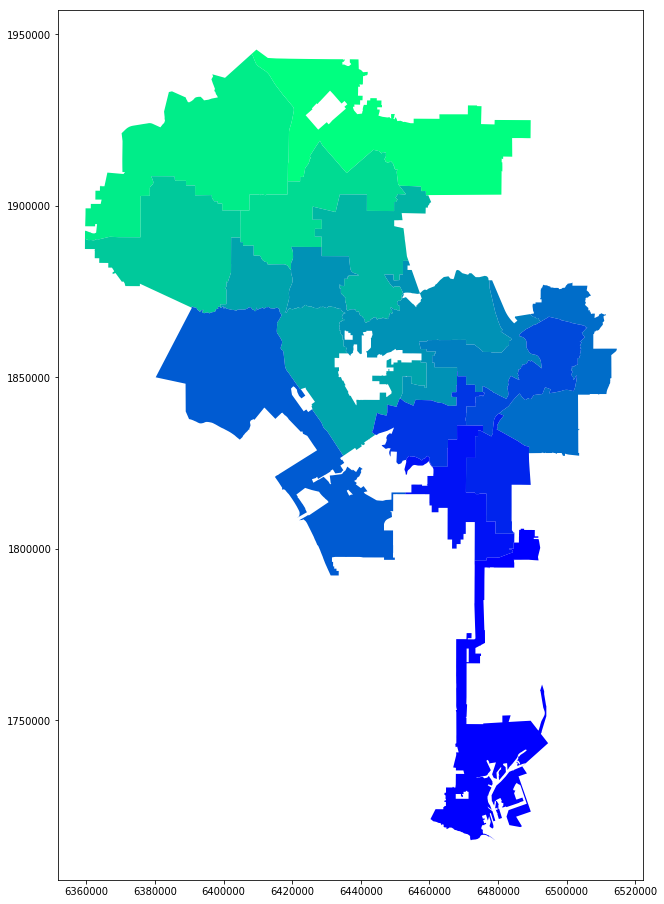

In [24]:
gdf.plot(figsize=(16,16), cmap='winter_r', scheme='quantiles')

In [44]:
#filter Northeast dataframe
df_northeast = df[df.area_name == 'Northeast']

In [ ]:
#map of crime in LA
m = folium.Map(location=[34.0582838, -118.3221608], tiles='stamentoner', zoom_start=11)
mc = MarkerCluster().add_to(m)

popup_string = str(df.datetime_series) + " " + df.crime_code_description
folium.CircleMarker(location=[df.location[0:100]], number_of_sides=4, popup=popup_string, radius=6).add_to(mc)

#folium.CircleMarker(df, radius=10, ).add_to(m)

FastMarkerCluster(df.location_, callback=None)

folium.plugins.Fullscreen(position='bottomright').add_to(m)

folium.map.LayerControl().add_to(m)
#folium.map.Layer(name="temp").add_to(m)
            
#m.save('/Users/nonoumasy/Desktop/crime_map.html')
m.save('/Users/nonoumasy/Desktop/northeast.html')
m

#sends an sms once this cell finishes executing
#os.system('python send_sms.py')

In [18]:
#When did most crimes occured in terms of days of the week?
df.weekday_name.value_counts().sort_index()

Friday       293485
Monday       271685
Saturday     274028
Sunday       262138
Thursday     268350
Tuesday      266788
Wednesday    270051
Name: weekday_name, dtype: int64

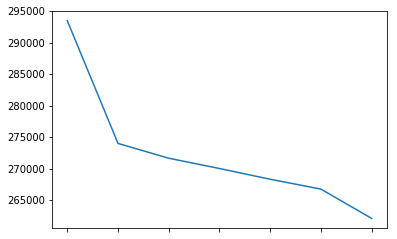

In [19]:
#When did most crimes occured in terms of days of the week?
df.weekday_name.value_counts().plot()

In [20]:
#When did crimes occured in terms of specific days?
df.datetime_series.value_counts()[0:5]

2010-01-01 12:00:00    556
2011-01-01 12:00:00    517
2012-01-01 12:00:00    428
2011-01-01 00:01:00    383
2013-01-01 12:00:00    356
Name: datetime_series, dtype: int64

## Climax

In [22]:
#Is crime increasing or decreasing in time?
df.datetime_series.dt.year.value_counts().sort_index()[0:9]

2010    208753
2011    200384
2012    201094
2013    192128
2014    194903
2015    214686
2016    224445
2017    229531
2018    224745
Name: datetime_series, dtype: int64

Text(0.5, 1.0, 'Is Crime going up or down in the city of Angels?')

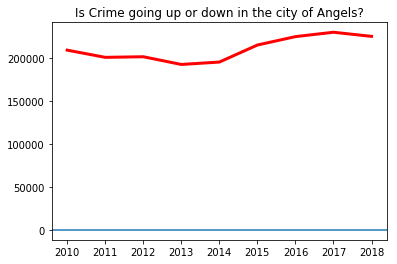

In [38]:
#Is crime increasing or decreasing in time? Show
trend = df.datetime_series.dt.year.value_counts().sort_index()[0:9]
plt.plot(trend, linewidth=3, color='red')
plt.axhline(y=0)
plt.title('Is Crime going up or down in the city of Angels?')

## Resolution

## References used
LAPD Crime 
http://www.lapdonline.org/inside_the_lapd/content_basic_view/27333
Crime Classification Grouping:
https://www.nap.edu/read/23492/chapter/7#128